**Nhận diện số**

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
transform = transforms.ToTensor()  # tự đưa về [0,1] và shape (1,28,28)

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)


In [3]:
print(train_ds.data.shape, train_ds.data.dtype)
print(train_ds.targets.shape, train_ds.targets.dtype)


torch.Size([60000, 28, 28]) torch.uint8
torch.Size([60000]) torch.int64


In [54]:
print(train_ds.data[1])

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,  51, 159, 253, 159,  50,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          48, 238, 252, 252, 252, 237,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

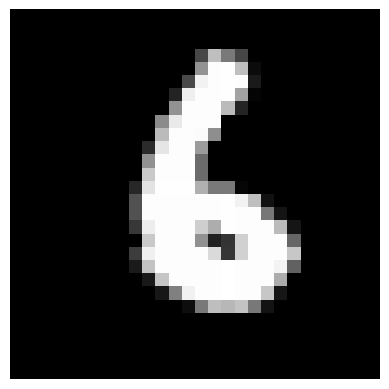

In [4]:
img = train_ds.data[36]          # (28,28) uint8 0..255
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

In [11]:
x_train = train_ds.data.float().div(255.0)
y_train = train_ds.targets.float().numpy() 

x_test = test_ds.data.float().div(255.0)
y_test = test_ds.targets.float().numpy()

print(x_train.shape, y_train.shape)

torch.Size([60000, 28, 28]) (60000,)


In [12]:
x_train = x_train.unsqueeze(1)
x_test = x_test.unsqueeze(1)

y_train = torch.as_tensor(y_train, dtype=torch.long)
y_test = torch.as_tensor(y_test, dtype=torch.long)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([60000, 1, 28, 28]) torch.Size([10000, 1, 28, 28])
torch.Size([60000]) torch.Size([10000])


In [13]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42
)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

torch.Size([54000, 1, 28, 28]) torch.Size([54000])
torch.Size([6000, 1, 28, 28]) torch.Size([6000])


In [22]:
class MLP:
    def __init__(self, input_dim, output_dim=10, lr=0.01, epochs=10000, batch_size=256):
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.epochs = epochs
        self.batch_size = batch_size
        self.list_loss_train = []
        self.list_loss_val = []
        self.best_train_model = None
        self.best_val_model = None

    def train(self, x_train, y_train, x_val, y_val):
        if isinstance(x_train, torch.Tensor):
            x_train_tensor = x_train.float()
        else:
            x_train_tensor = torch.FloatTensor(x_train)

        if isinstance(y_train, torch.Tensor):
            y_train_tensor = y_train.long()
        else:
            y_train_tensor = torch.LongTensor(y_train)

        if isinstance(x_val, torch.Tensor):
            x_val_tensor = x_val.float()
        else:
            x_val_tensor = torch.FloatTensor(x_val)

        if isinstance(y_val, torch.Tensor):
            y_val_tensor = y_val.long()
        else:
            y_val_tensor = torch.LongTensor(y_val)

        n = x_train_tensor.shape[0]

        for epoch in range(self.epochs):
            self.model.train()

            # shuffle index cho mỗi epoch
            perm = torch.randperm(n)

            # --- train theo mini-batch ---
            for start in range(0, n, self.batch_size):
                idx = perm[start:start + self.batch_size]
                xb = x_train_tensor[idx]
                yb = y_train_tensor[idx]

                self.optimizer.zero_grad()
                outputs_train = self.forward(xb)
                loss_train = self.criterion(outputs_train, yb)
                loss_train.backward()
                self.optimizer.step()

            outputs_train_full = self.forward(x_train_tensor)
            loss_train_full = self.criterion(outputs_train_full, y_train_tensor)

            outputs_val = self.forward(x_val_tensor)
            loss_val = self.criterion(outputs_val, y_val_tensor)

            self.list_loss_train.append(loss_train_full.item())
            self.list_loss_val.append(loss_val.item())

            print(f'Epoch [{epoch+1}/{self.epochs}], Loss_train: {loss_train_full.item():.4f}, Loss_val: {loss_val.item():.4f}')

    def forward(self, x):
        outputs = self.model(x)
        return outputs


**Yêu cầu đề**

1/ Conv2d
- Từ 1 kênh chuyển thành 6 kênh (N, 1, 28, 28) -> (N, 6, 28, 28)
- Sử dụng padding = "same" để giữ nguyên (28x28) kích thước ảnh sau khi qua lớp Conv2d

2/ AvgPool2d (KERNEL_SIZE=2, STRIDE=2)
- Giảm kích thước ảnh xuống 1 nửa (N, 6, 28, 28) -> (N, 6, 14, 14)

3/ ReLU

4/ Conv2d (6 -> 16, kernel = 5)
- Từ 6 kênh chuyển thành 16 kênh (N, 6, 14, 14)
- Sử dụng padding = 0 (valid) để giảm kích thước ảnh sau khi qua lớp Conv2d
- Kích thước ảnh sau khi qua lớp Conv2d: (N, 16, 10, 10)

5/ AvgPool2d (KERNEL_SIZE=2, STRIDE=2)
- Giảm kích thước ảnh xuống 1 nửa (N, 16, 10, 10) -> (N, 16, 5, 5)

6/ ReLU

7/ Flatten
- Chuyển đổi tensor từ (N, 16, 5, 5) -> (N, 400) 

8/ MLP ( 400 -> 120 -> 84 -> 10)


In [15]:
class LeNetCNN:
    def __init__(self, output_dim=10, lr=2e-4, epochs=10, batch_size=256):
        self.model = nn.Sequential(
            # Conv block 1
            nn.Conv2d(1, 6, kernel_size=5, padding="same"),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.ReLU(),

            # Conv block 2
            nn.Conv2d(6, 16, kernel_size=5),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.ReLU(),

            # Flatten + MLP head
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.Linear(120, 84),
            nn.Linear(84, output_dim)
        )

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.epochs = epochs
        self.batch_size = batch_size
        self.list_loss_train = []
        self.list_loss_val = []
        self.best_train_model = None
        self.best_val_model = None

    def train(self, x_train, y_train, x_val, y_val):
        x_train_tensor = x_train.float() if isinstance(x_train, torch.Tensor) else torch.FloatTensor(x_train)
        y_train_tensor = y_train.long()  if isinstance(y_train, torch.Tensor) else torch.LongTensor(y_train)

        x_val_tensor = x_val.float() if isinstance(x_val, torch.Tensor) else torch.FloatTensor(x_val)
        y_val_tensor = y_val.long()  if isinstance(y_val, torch.Tensor) else torch.LongTensor(y_val)

        n = x_train_tensor.shape[0]

        best_train_loss = float("inf")
        best_val_loss = float("inf")

        for epoch in range(self.epochs):
            self.model.train()

            perm = torch.randperm(n)

            # --- train mini-batch ---
            for start in range(0, n, self.batch_size):
                idx = perm[start:start + self.batch_size]
                xb = x_train_tensor[idx]   # (B,1,28,28)
                yb = y_train_tensor[idx]   # (B,)

                self.optimizer.zero_grad()
                logits = self.forward(xb)              # (B,10)
                loss = self.criterion(logits, yb)
                loss.backward()
                self.optimizer.step()

            # --- tính loss full train/val để log ---
            self.model.eval()
            with torch.no_grad():
                train_logits_full = self.forward(x_train_tensor)
                loss_train_full = self.criterion(train_logits_full, y_train_tensor)

                val_logits = self.forward(x_val_tensor)
                loss_val = self.criterion(val_logits, y_val_tensor)

            self.list_loss_train.append(loss_train_full.item())
            self.list_loss_val.append(loss_val.item())

            # lưu best
            if loss_train_full.item() < best_train_loss:
                best_train_loss = loss_train_full.item()
                self.best_train_model = {k: v.clone() for k, v in self.model.state_dict().items()}

            if loss_val.item() < best_val_loss:
                best_val_loss = loss_val.item()
                self.best_val_model = {k: v.clone() for k, v in self.model.state_dict().items()}

            print(
                f'Epoch [{epoch+1}/{self.epochs}], '
                f'Loss_train: {loss_train_full.item():.4f}, '
                f'Loss_val: {loss_val.item():.4f}'
            )

    def forward(self, x):
        return self.model(x)

In [16]:
model = LeNetCNN(output_dim=10, lr=0.01, epochs=100, batch_size=256)
model.train(x_train, y_train, x_val, y_val)

Epoch [1/100], Loss_train: 0.1075, Loss_val: 0.1117
Epoch [2/100], Loss_train: 0.0702, Loss_val: 0.0728
Epoch [3/100], Loss_train: 0.0774, Loss_val: 0.0832
Epoch [4/100], Loss_train: 0.0565, Loss_val: 0.0595
Epoch [5/100], Loss_train: 0.0531, Loss_val: 0.0666
Epoch [6/100], Loss_train: 0.0815, Loss_val: 0.0919
Epoch [7/100], Loss_train: 0.0493, Loss_val: 0.0652
Epoch [8/100], Loss_train: 0.0492, Loss_val: 0.0562
Epoch [9/100], Loss_train: 0.0631, Loss_val: 0.0779
Epoch [10/100], Loss_train: 0.0376, Loss_val: 0.0559
Epoch [11/100], Loss_train: 0.0422, Loss_val: 0.0584
Epoch [12/100], Loss_train: 0.0420, Loss_val: 0.0641
Epoch [13/100], Loss_train: 0.0397, Loss_val: 0.0588
Epoch [14/100], Loss_train: 0.0427, Loss_val: 0.0811
Epoch [15/100], Loss_train: 0.0341, Loss_val: 0.0681
Epoch [16/100], Loss_train: 0.0470, Loss_val: 0.0836
Epoch [17/100], Loss_train: 0.0347, Loss_val: 0.0681
Epoch [18/100], Loss_train: 0.0381, Loss_val: 0.0641
Epoch [19/100], Loss_train: 0.0347, Loss_val: 0.0600
Ep

In [ ]:
# Lưu x_test gốc cho CNN trước khi flatten (reload from dataset)
x_test_cnn = test_ds.data.float().div(255.0).unsqueeze(1)

x_train_mlp = x_train.view(x_train.shape[0], -1)
x_val_mlp = x_val.view(x_val.shape[0], -1)
x_test_mlp = x_test.view(x_test.shape[0], -1)

# Convert to numpy if needed
if isinstance(y_train, torch.Tensor):
    y_train_np = y_train.numpy()
else:
    y_train_np = y_train
    
if isinstance(y_val, torch.Tensor):
    y_val_np = y_val.numpy()
else:
    y_val_np = y_val
    
if isinstance(y_test, torch.Tensor):
    y_test_np = y_test.numpy()
else:
    y_test_np = y_test

model2 = MLP(input_dim=x_train_mlp.shape[1], lr=0.01, epochs=100, batch_size=256)
model2.train(x_train_mlp, y_train_np, x_val_mlp, y_val_np)

Epoch [1/100], Loss_train: 2.2818, Loss_val: 2.2825
Epoch [2/100], Loss_train: 2.2400, Loss_val: 2.2405
Epoch [3/100], Loss_train: 2.1222, Loss_val: 2.1225
Epoch [4/100], Loss_train: 1.7165, Loss_val: 1.7160
Epoch [5/100], Loss_train: 1.0874, Loss_val: 1.0891
Epoch [6/100], Loss_train: 0.7705, Loss_val: 0.7690
Epoch [7/100], Loss_train: 0.6192, Loss_val: 0.6159
Epoch [8/100], Loss_train: 0.5366, Loss_val: 0.5330
Epoch [9/100], Loss_train: 0.4861, Loss_val: 0.4829
Epoch [10/100], Loss_train: 0.4489, Loss_val: 0.4449
Epoch [11/100], Loss_train: 0.4226, Loss_val: 0.4189
Epoch [12/100], Loss_train: 0.4030, Loss_val: 0.4011
Epoch [13/100], Loss_train: 0.3856, Loss_val: 0.3827
Epoch [14/100], Loss_train: 0.3721, Loss_val: 0.3703
Epoch [15/100], Loss_train: 0.3590, Loss_val: 0.3572
Epoch [16/100], Loss_train: 0.3474, Loss_val: 0.3455
Epoch [17/100], Loss_train: 0.3366, Loss_val: 0.3361
Epoch [18/100], Loss_train: 0.3277, Loss_val: 0.3268
Epoch [19/100], Loss_train: 0.3183, Loss_val: 0.3171
Ep

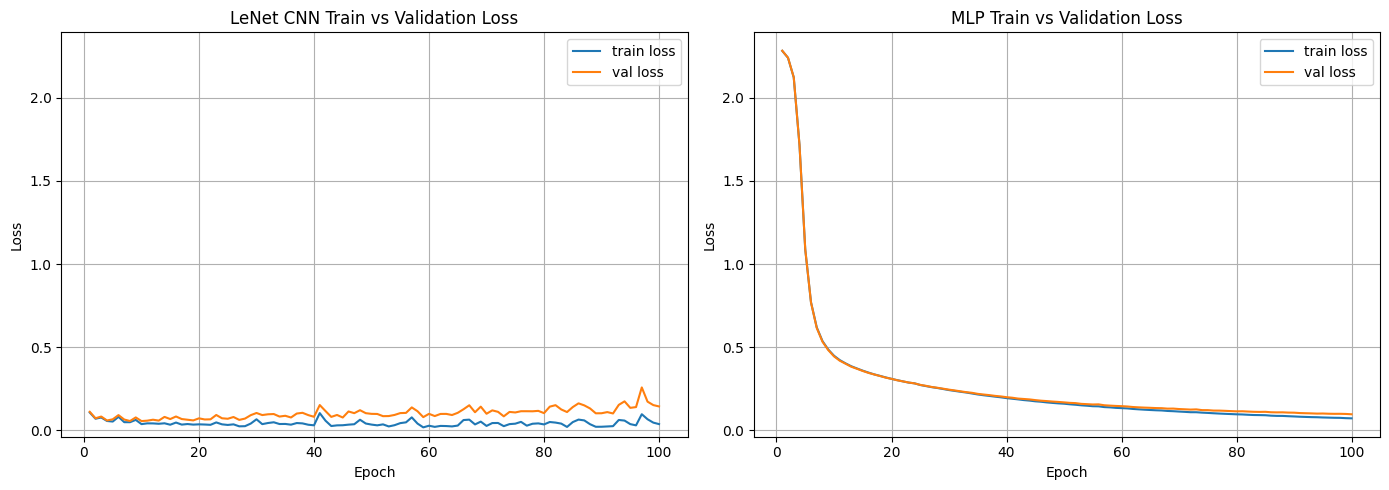

In [28]:
epochs1 = range(1, len(model.list_loss_train) + 1)
epochs2 = range(1, len(model2.list_loss_train) + 1)

# Vẽ cả 2 mô hình trên cùng 1 figure với cùng thang đo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: LeNet CNN
ax1.plot(epochs1, model.list_loss_train, label="train loss")
ax1.plot(epochs1, model.list_loss_val, label="val loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("LeNet CNN Train vs Validation Loss")
ax1.legend()
ax1.grid(True)

# Plot 2: MLP
ax2.plot(epochs2, model2.list_loss_train, label="train loss")
ax2.plot(epochs2, model2.list_loss_val, label="val loss")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_title("MLP Train vs Validation Loss")
ax2.legend()
ax2.grid(True)

# Đặt cùng y-axis scale cho cả 2 subplot để so sánh công bằng
y_min = min(ax1.get_ylim()[0], ax2.get_ylim()[0])
y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim([y_min, y_max])
ax2.set_ylim([y_min, y_max])

plt.tight_layout()
plt.show()

In [29]:
# Evaluate LeNet CNN on test set
x_test_cnn_tensor = x_test_cnn.float()
outputs_test = model.forward(x_test_cnn_tensor)
_, predicted = torch.max(outputs_test, 1)   
accuracy = (predicted.numpy() == y_test_np).mean()
print(f'Test Accuracy LeNet CNN: {accuracy * 100:.2f}%')

# Evaluate MLP on test set
x_test_mlp_tensor = x_test_mlp.float()
outputs_test_mlp = model2.forward(x_test_mlp_tensor)
_, predicted_mlp = torch.max(outputs_test_mlp, 1)
accuracy_mlp = (predicted_mlp.numpy() == y_test_np).mean()
print(f'Test Accuracy MLP: {accuracy_mlp * 100:.2f}%')

Test Accuracy LeNet CNN: 97.89%
Test Accuracy MLP: 96.96%
